[]

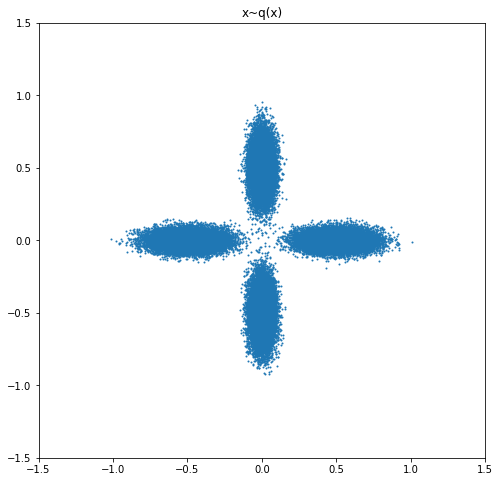

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class CustomDataSet(Dataset):

    def __init__(self, n_data, n_class):
        self.n_data = n_data
        self.n_class = n_class
        degree = 2.0 * np.pi / n_class
        data = np.random.randn(n_data, 2)
        count = 0
        label = np.zeros((n_data), dtype=np.long)
        while count < n_data:
            cls = count % n_class
            x = 0.12 * data[count][0] + 0.5
            y = 0.04 * data[count][1]
            data[count][0] = np.cos(cls * degree) * x - np.sin(cls * degree) * y
            data[count][1] = np.sin(cls * degree) * x + np.cos(cls * degree) * y
            label[count] = cls
            count += 1
        self.data = torch.from_numpy(data).float()
        self.label = torch.from_numpy(label).long()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



dataset = CustomDataSet(80000, 4)
sample_data = dataset.data.numpy()
plt.figure(figsize=(8, 8))
plt.title('x~q(x)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(sample_data[:, 0], sample_data[:, 1], s=1)
plt.plot()

In [7]:
def log_likelihood_stdnormal(x):
    return -0.5 * (np.log(2.0 * np.pi) + (x**2))


class Resnet(nn.Module):
    def __init__(self, n_in, n_hid, n_out, n_res_layers):
        super().__init__()
        self.layer_in = nn.Sequential(nn.Linear(n_in, n_hid), nn.LeakyReLU())
        self.res_nets = nn.ModuleList([nn.Sequential(nn.Linear(n_hid, n_hid), nn.LeakyReLU()) for _ in range(n_res_layers)])
        self.layer_out = nn.Linear(n_hid, n_out)

    def forward(self, x):
        x = self.layer_in(x)
        for resnet in self.res_nets:
            x = x + resnet(x)
        return self.layer_out(x)


class RealNVP_Block(nn.Module):
    def __init__(self, d, num_variables, n_hid, n_res_layers):
        super().__init__()
        self.d = d
        self.n = num_variables
        self.net = Resnet(self.d, n_hid, (num_variables - d) * 2, n_res_layers)
        perm_order = torch.randperm(num_variables)
        self.idx_fixed = perm_order[:d]
        self.idx_trans = perm_order[d:]


    def forward(self, x):
        params = self.net(x[:, self.idx_fixed])
        mu, s = params[:, :(self.n - self.d)], F.softplus(params[:, (self.n - self.d):])
        x[:, self.idx_trans] *= s
        x[:, self.idx_trans] += mu
        log_det = torch.log(s + 1e-20).sum(dim=1)
        return x, log_det

    def inverse(self, z):
        params = self.net(z[:, self.idx_fixed])
        mu, s = params[:, :(self.n - self.d)], F.softplus(params[:, (self.n - self.d):])
        z[:, self.idx_trans] -= mu
        z[:, self.idx_trans] /= s
        return z
        



class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()
        self.realnvp = nn.ModuleList([
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2),       
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2),       
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2),       
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2),       
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2),
            RealNVP_Block(d=1, num_variables=2, n_hid=128, n_res_layers=2)
        ])

    def forward(self, x):
        log_det = 0.0
        for flow in self.realnvp:
            x, ld = flow(x)
            log_det += ld
        return x, log_det

    def sample(self, z):
        for flow in reversed(self.realnvp):
            z = flow.inverse(z)
        return z

In [8]:
model = RealNVP()
solver = torch.optim.Adam(model.parameters(), lr=1e-3)
mbsz = 64
loader = DataLoader(dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [9]:
y = model.sample(torch.randn(8, 2))

In [10]:
NLL = []
NLL_FULL = []
num_epochs = 1000
for epoch in range(num_epochs):
    NLL.append(0.0)
    NLL_FULL.append(0.0)
    for x in loader:
        solver.zero_grad()
        z, log_det = model(x)
        log_px = log_likelihood_stdnormal(z).sum(dim=1).mean()
        logdet = log_det.mean() 
        loss = -(log_px + logdet)
        loss.backward()
        solver.step()
        NLL[-1] -= log_px.item()
        NLL_FULL[-1] += loss.item()
    NLL[-1] /= len(loader)
    NLL_FULL[-1] /= len(loader)
    if epoch % 100 == 99:
        print(epoch, ':',NLL_FULL[-1])



99 : -1.0244374382019044


KeyboardInterrupt: ignored

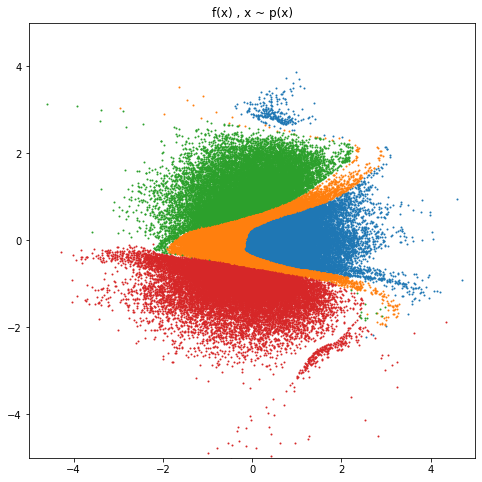

In [15]:
model.eval()
plt.figure(figsize=(8, 8))
plt.title('f(x) , x ~ p(x)')
for c in range(dataset.n_class):
    x = dataset.data[dataset.label == c]
    y, _ = model(x)
    y = y.detach()
    plt.scatter(y[:, 0], y[:, 1], s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

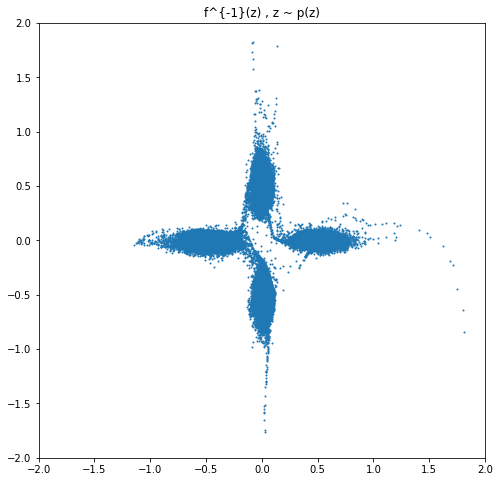

In [16]:
model.eval()
plt.figure(figsize=(8, 8))
plt.title('f^{-1}(z) , z ~ p(z)')

x = model.sample(torch.randn(40000, 2))
x = x.detach()
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()